# Model experiments for Animals classification

In [57]:
from enum import Enum
from pathlib import Path
from typing import Any
from dataclasses import dataclass
import PIL
import json
import cv2

import tqdm
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report

import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
from torchvision.io import decode_image
import torch.utils.model_zoo as model_zoo

## Dataset

In [58]:
class EnglishLabel(str, Enum):
    DOG = "dog"
    HORSE = "horse"
    ELEPHANT = "elephant"
    BUTTERFLY = "butterfly"
    CHICKEN = "chicken"
    CAT = "cat"
    COW = "cow"
    SHEEP = "sheep"
    SPIDER = "spider"
    SQUIRREL = "squirrel"


class ItalianLabel(str, Enum):
    CANE = "cane"
    CAVALLO = "cavallo"
    ELEFANTE = "elefante"
    FARFALLA = "farfalla"
    GALLINA = "gallina"
    GATTO = "gatto"
    MUCCA = "mucca"
    PECORA = "pecora"
    RAGNO = "ragno"
    SCOIATTOLO = "scoiattolo"


def translate_english_to_italian(label: EnglishLabel) -> ItalianLabel:
    translate = {
        EnglishLabel.DOG: ItalianLabel.CANE,
        EnglishLabel.HORSE: ItalianLabel.CAVALLO,
        EnglishLabel.ELEPHANT: ItalianLabel.ELEFANTE,
        EnglishLabel.BUTTERFLY: ItalianLabel.FARFALLA,
        EnglishLabel.CHICKEN: ItalianLabel.GALLINA,
        EnglishLabel.CAT: ItalianLabel.GATTO,
        EnglishLabel.COW: ItalianLabel.MUCCA,
        EnglishLabel.SHEEP: ItalianLabel.PECORA,
        EnglishLabel.SPIDER: ItalianLabel.RAGNO,
        EnglishLabel.SQUIRREL: ItalianLabel.SCOIATTOLO,
    }
    return translate[label]


def translate_italian_to_english(label: ItalianLabel) -> EnglishLabel:
    translate = {
        ItalianLabel.CANE: EnglishLabel.DOG,
        ItalianLabel.CAVALLO: EnglishLabel.HORSE,
        ItalianLabel.ELEFANTE: EnglishLabel.ELEPHANT,
        ItalianLabel.FARFALLA: EnglishLabel.BUTTERFLY,
        ItalianLabel.GALLINA: EnglishLabel.CHICKEN,
        ItalianLabel.GATTO: EnglishLabel.CAT,
        ItalianLabel.MUCCA: EnglishLabel.COW,
        ItalianLabel.PECORA: EnglishLabel.SHEEP,
        ItalianLabel.RAGNO: EnglishLabel.SPIDER,
        ItalianLabel.SCOIATTOLO: EnglishLabel.SQUIRREL,
    }
    return translate[label]


def build_dataframes(
    data_dir: str | Path,
    english_labels: list[EnglishLabel],
    test_size: float = 0.2,
    random_state: int | None = None,
) -> tuple[pd.DataFrame, pd.DataFrame, int]:
    data_dir = Path(data_dir)
    if not data_dir.exists() or not data_dir.is_dir():
        raise ValueError(f"Invalid data directory: {data_dir}")

    italian_labels = [translate_english_to_italian(lab) for lab in english_labels]
    num_labels = len(italian_labels)

    data = []
    for label_idx, italian_label in enumerate(italian_labels):
        label_dir = data_dir / italian_label.value
        for fpath in label_dir.glob("*"):
            if fpath.is_file():
                data.append(
                    {
                        "italian_label": italian_label,
                        "english_label": english_labels[label_idx],
                        "label_idx": label_idx,
                        "path": str(fpath),
                    }
                )
    data_df = pd.DataFrame(data)

    train_df, test_df = train_test_split(
        data_df, test_size=test_size, random_state=random_state
    )
    return train_df, test_df, num_labels


class AnimalsDataset(Dataset):
    def __init__(
        self, data_df: pd.DataFrame, num_labels: int, transform: Any | None = None
    ):
        self.data_df = data_df
        self.num_labels = num_labels
        self.transform = transform

    def __len__(self) -> int:
        return len(self.data_df)

    def __getitem__(self, idx: int) -> tuple[torch.Tensor, torch.Tensor]:
        entry = self.data_df.iloc[idx]
        image = decode_image(entry["path"])
        if self.transform is not None:
            image = self.transform(image)

        labels = np.zeros(self.num_labels, dtype=int)
        labels[entry["label_idx"]] = 1
        return image, torch.tensor(labels)

In [59]:
train_df, test_df, num_labels = build_dataframes(
    "../data/raw-img",
    [EnglishLabel.DOG, EnglishLabel.HORSE],
    test_size=0.2,
    random_state=42,
)

### ResNet-18

In [60]:
from torchvision.models import ResNet18_Weights
from animcl.models.attbranchnet import resnet18, ResNet, BasicBlock, model_urls

In [61]:
train_dataset = AnimalsDataset(
    train_df, num_labels, ResNet18_Weights.DEFAULT.transforms()
)
test_dataset = AnimalsDataset(
    test_df, num_labels, ResNet18_Weights.DEFAULT.transforms()
)

train_dataloader = DataLoader(train_dataset, batch_size=64, shuffle=True)
test_dataloader = DataLoader(test_dataset, batch_size=64, shuffle=False)

In [62]:
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [63]:
def count_parameters(model: nn.Module, only_trainable: bool = True) -> int:
    if only_trainable:
        return sum(p.numel() for p in model.parameters() if p.requires_grad)
    else:
        return sum(p.numel() for p in model.parameters())


def load_resnet18_wrong(num_labels: int) -> ResNet:
    model = resnet18(pretrained=True)
    model.fc = nn.Linear(model.fc.in_features, num_labels)
    return model


def load_base_resnet18(
    num_labels: int,
    attn_conv_channels: tuple[int, int],
    default_initialization: bool = True,
    attn_residual_connection: bool = True,
) -> ResNet:
    model = ResNet(
        BasicBlock,
        [2, 2, 2, 2],
        attn_conv_channels=attn_conv_channels,
        num_classes=num_labels,
        default_initialization=default_initialization,
        attn_residual_connection=attn_residual_connection,
    )
    weights = model_zoo.load_url(model_urls["resnet18"])
    del weights["fc.weight"]
    del weights["fc.bias"]
    model.load_state_dict(weights, strict=False)
    return model


def load_trained_resnet18(
    weights_path: str | Path,
    num_labels: int,
    attn_conv_channels: tuple[int, int],
    default_initialization: bool = True,
    attn_residual_connection: bool = True,
) -> ResNet:
    model = ResNet(
        BasicBlock,
        [2, 2, 2, 2],
        attn_conv_channels=attn_conv_channels,
        num_classes=num_labels,
        default_initialization=default_initialization,
        attn_residual_connection=attn_residual_connection,
    )
    weights = torch.load(weights_path, map_location=DEVICE)
    model.load_state_dict(weights, strict=True)
    return model

In [64]:
# wrong_model = load_resnet18_wrong(num_labels)
# correct_model = load_base_resnet18(num_labels)

# print(f"{count_parameters(wrong_model) = }")
# print(f"{count_parameters(correct_model) = }")

In [65]:
# model.load_state_dict(torch.load("../abn2/model_epoch_19.pth", weights_only=True))
# model.to(DEVICE)

# model.load_state_dict(torch.load("../abn3_correct/model_epoch_19.pth", weights_only=True))
# model.to(device)

In [66]:
@dataclass
class TrainConfig:
    num_epochs: int
    start_epoch_number: int
    device: torch.device
    save_dir: Path | str | None
    attention_loss_weight: float
    perception_loss_weight: float
    learning_rate: float
    attention_regularization: float | None


@dataclass
class TrainHistory:
    train_losses: list[float]
    val_losses: list[float]

In [67]:
def save_history(history: TrainHistory, save_path: Path | str) -> None:
    save_path = Path(save_path)
    with open(save_path, "w") as f:
        json.dump(
            {
                "train_losses": history.train_losses,
                "val_losses": history.val_losses,
            },
            f,
            indent=4,
        )


def train_model(
    model: nn.Module,
    train_dataloader: DataLoader,
    valid_dataloader: DataLoader,
    config: TrainConfig,
) -> TrainHistory:
    if config.save_dir is not None:
        save_dir = Path(config.save_dir)
        save_dir.mkdir(exist_ok=True)
    else:
        save_dir = None

    optimizer = torch.optim.Adam(model.parameters(), lr=config.learning_rate)
    loss_fn = torch.nn.CrossEntropyLoss()

    history = TrainHistory(train_losses=[], val_losses=[])

    model.train()
    model.to(config.device)

    for epoch in range(
        config.start_epoch_number, config.start_epoch_number + config.num_epochs
    ):
        model.train()
        loss_accum = 0.0
        for images, labels in tqdm.tqdm(train_dataloader, desc=f"Epoch {epoch}"):
            images = images.to(config.device)
            labels = labels.to(config.device)

            optimizer.zero_grad()
            att_outputs, outputs, [attn, _, _] = model(images)
            att_loss = loss_fn(att_outputs, labels.argmax(axis=1))
            per_loss = loss_fn(outputs, labels.argmax(axis=1))
            loss = (
                att_loss * config.attention_loss_weight
                + per_loss * config.perception_loss_weight
            )
            if config.attention_regularization is not None:
                loss += config.attention_regularization * attn.mean()
            loss.backward()
            optimizer.step()

            loss_accum += loss.item()

        with torch.no_grad():
            model.eval()
            valid_loss_accum = 0.0
            for images, labels in tqdm.tqdm(
                valid_dataloader, desc=f"Validating epoch {epoch}"
            ):
                images = images.to(config.device)
                labels = labels.to(config.device)

                att_outputs, outputs, _ = model(images)
                att_loss = loss_fn(att_outputs, labels.argmax(axis=1))
                per_loss = loss_fn(outputs, labels.argmax(axis=1))
                valid_loss = (
                    att_loss * config.attention_loss_weight
                    + per_loss * config.perception_loss_weight
                )
                valid_loss_accum += valid_loss.item()

        avg_loss = loss_accum / len(train_dataloader)
        history.train_losses.append(avg_loss)
        print(f"Training Loss: {avg_loss}")
        avg_valid_loss = valid_loss_accum / len(valid_dataloader)
        history.val_losses.append(avg_valid_loss)
        print(f"Validation Loss: {avg_valid_loss}")

        if save_dir is not None:
            torch.save(model.state_dict(), save_dir / f"model_epoch_{epoch}.pth")

    return history

In [12]:
model = load_base_resnet18(
    num_labels, (200, 200), default_initialization=True, attn_residual_connection=False
)
model.to(DEVICE)
# model = load_resnet18_wrong(num_labels)

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

In [13]:
save_dir = "../abn_weights_200_200_noresid_regul05_bigpercw"

history = train_model(
    model,
    train_dataloader,
    test_dataloader,
    TrainConfig(
        start_epoch_number=0,
        num_epochs=20,
        device=DEVICE,
        attention_loss_weight=0.1,
        perception_loss_weight=0.9,
        save_dir=save_dir,
        learning_rate=1e-3,
        attention_regularization=0.5,
    ),
)

save_history(history, f"{save_dir}/history.json")

Validating epoch 0: 100%|██████████| 24/24 [00:06<00:00,  3.77it/s]


Training Loss: 0.5067081892109931
Validation Loss: 0.11668967362493277


Validating epoch 1: 100%|██████████| 24/24 [00:06<00:00,  3.70it/s]


Training Loss: 0.30802118857490257
Validation Loss: 0.17103319242596626


Validating epoch 2: 100%|██████████| 24/24 [00:06<00:00,  3.96it/s]


Training Loss: 0.29691768453476275
Validation Loss: 0.22280105203390121


Validating epoch 3: 100%|██████████| 24/24 [00:08<00:00,  2.96it/s]


Training Loss: 0.24799283704859146
Validation Loss: 0.16967846639454365


Validating epoch 4: 100%|██████████| 24/24 [00:06<00:00,  3.52it/s]


Training Loss: 0.2353430540954813
Validation Loss: 0.11944084761974712


Validating epoch 5: 100%|██████████| 24/24 [00:06<00:00,  3.76it/s]


Training Loss: 0.2343733420080327
Validation Loss: 0.3713045784582694


Validating epoch 6: 100%|██████████| 24/24 [00:07<00:00,  3.41it/s]


Training Loss: 0.20288130751949676
Validation Loss: 0.40831105535229045


Validating epoch 7: 100%|██████████| 24/24 [00:06<00:00,  3.47it/s]


Training Loss: 0.20092330016988388
Validation Loss: 0.10514353533896308


Validating epoch 8: 100%|██████████| 24/24 [00:06<00:00,  3.53it/s]


Training Loss: 0.1588416429276162
Validation Loss: 0.20093993516638875


Validating epoch 9: 100%|██████████| 24/24 [00:07<00:00,  3.38it/s]


Training Loss: 0.16384675559845377
Validation Loss: 0.10991328620972733


Validating epoch 10: 100%|██████████| 24/24 [00:06<00:00,  3.87it/s]


Training Loss: 0.14885368214008657
Validation Loss: 0.16552487403775254


Validating epoch 11: 100%|██████████| 24/24 [00:07<00:00,  3.29it/s]


Training Loss: 0.1694397006897216
Validation Loss: 0.18183360854163766


Validating epoch 12: 100%|██████████| 24/24 [00:05<00:00,  4.08it/s]


Training Loss: 0.13642174179883712
Validation Loss: 0.19093980318090567


Validating epoch 13: 100%|██████████| 24/24 [00:05<00:00,  4.06it/s]


Training Loss: 0.14477474242448807
Validation Loss: 0.1857503823315104


Validating epoch 14: 100%|██████████| 24/24 [00:05<00:00,  4.03it/s]


Training Loss: 0.1419922856098794
Validation Loss: 0.12423963006585836


Validating epoch 15: 100%|██████████| 24/24 [00:06<00:00,  3.98it/s]


Training Loss: 0.10658899591641223
Validation Loss: 0.10115570454703023


Validating epoch 16: 100%|██████████| 24/24 [00:05<00:00,  4.06it/s]


Training Loss: 0.09722164859797092
Validation Loss: 0.11809493589680642


Validating epoch 17: 100%|██████████| 24/24 [00:05<00:00,  4.03it/s]


Training Loss: 0.09116117664157077
Validation Loss: 0.1254617185331881


Validating epoch 18: 100%|██████████| 24/24 [00:05<00:00,  4.02it/s]


Training Loss: 0.09328102241171167
Validation Loss: 0.29711051005870104


Validating epoch 19: 100%|██████████| 24/24 [00:06<00:00,  3.66it/s]


Training Loss: 0.11807587615987088
Validation Loss: 0.16930869159599146


In [68]:
model = load_trained_resnet18(
    "../abn_weights_1000_1000/model_epoch_19.pth", num_labels, (1000, 1000)
)
model.to(DEVICE)

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

In [ ]:
def plot_distro(t: torch.Tensor):
    plt.figure(figsize=(10, 5))
    plt.hist(t.cpu().numpy().flatten(), bins=100)
    plt.title("Distribution of weights")
    plt.xlabel("Weight value")
    plt.ylabel("Frequency")
    plt.grid()
    plt.show()


for param in model.layer4[0].conv1.parameters():
    plot_distro(param.data)
    break

In [17]:
from typing import TypedDict

import torchvision.transforms.functional as F


class ExpSetup(TypedDict):
    name: str
    weights_path: str
    attn_conv_channels: tuple[int, int]
    default_initialization: bool
    attn_residual_connection: bool


class PredictResult(TypedDict):
    image_np: np.ndarray
    att_np: np.ndarray
    true_label: int
    pred_label: int


def load_predict_setups(
    setups: list[ExpSetup],
    num_labels: int,
    dataset: AnimalsDataset,
    idxs: list[int],
) -> list[list[PredictResult]]:
    results = []
    for i, setup in enumerate(setups):
        results.append([])
        model = load_trained_resnet18(
            setup["weights_path"],
            num_labels,
            setup["attn_conv_channels"],
            setup["default_initialization"],
            setup["attn_residual_connection"],
        )
        model.to(DEVICE)

        model.eval()
        for idx in idxs:
            image, labels = dataset[idx]
            with torch.no_grad():
                att_outputs, outputs, [att, feats, per] = model(image[None].to(DEVICE))
            image_np = image.cpu().numpy().transpose((1, 2, 0))
            att_np = (
                F.resize(
                    att, image_np.shape[:2], interpolation=F.InterpolationMode.BICUBIC
                )
                .detach()
                .cpu()
                .numpy()[0, 0]
            )

            true_label = labels.argmax().item()
            pred_label = outputs.argmax().item()

            results[-1].append(
                {
                    "image_np": image_np,
                    "att_np": att_np,
                    "true_label": true_label,
                    "pred_label": pred_label,
                }
            )

    return results

In [44]:
setups: list[ExpSetup] = [
    {
        "name": "abn_weights_50_50",
        "weights_path": "../abn_weights_50_50/model_epoch_19.pth",
        "attn_conv_channels": (50, 50),
        "default_initialization": True,
        "attn_residual_connection": True,
    },
    {
        "name": "abn_weights_200_200",
        "weights_path": "../abn_weights_200_200/model_epoch_19.pth",
        "attn_conv_channels": (200, 200),
        "default_initialization": True,
        "attn_residual_connection": True,
    },
    {
        "name": "abn_weights_200_200_noresid",
        "weights_path": "../abn_weights_200_200_noresid/model_epoch_19.pth",
        "attn_conv_channels": (200, 200),
        "default_initialization": True,
        "attn_residual_connection": False,
    },
    {
        "name": "abn_weights_200_200_noresid_regul05_bigpercw",
        "weights_path": "../abn_weights_200_200_noresid_regul05_bigpercw/model_epoch_19.pth",
        "attn_conv_channels": (200, 200),
        "default_initialization": True,
        "attn_residual_connection": False,
    },
    {
        "name": "abn_weights_1000_1000",
        "weights_path": "../abn_weights_1000_1000/model_epoch_19.pth",
        "attn_conv_channels": (1000, 1000),
        "default_initialization": True,
        "attn_residual_connection": True,
    },
]

pred_results = load_predict_setups(
    setups,
    num_labels,
    test_dataset,
    idxs=[503, 805, 1004, 550, 850, 1054],
)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-2.117904..2.64].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-2.117904..2.64].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-2.117904..2.5179958].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-2.117904..2.64].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-2.1007793..2.5005665].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-2.117904..2.5528543].


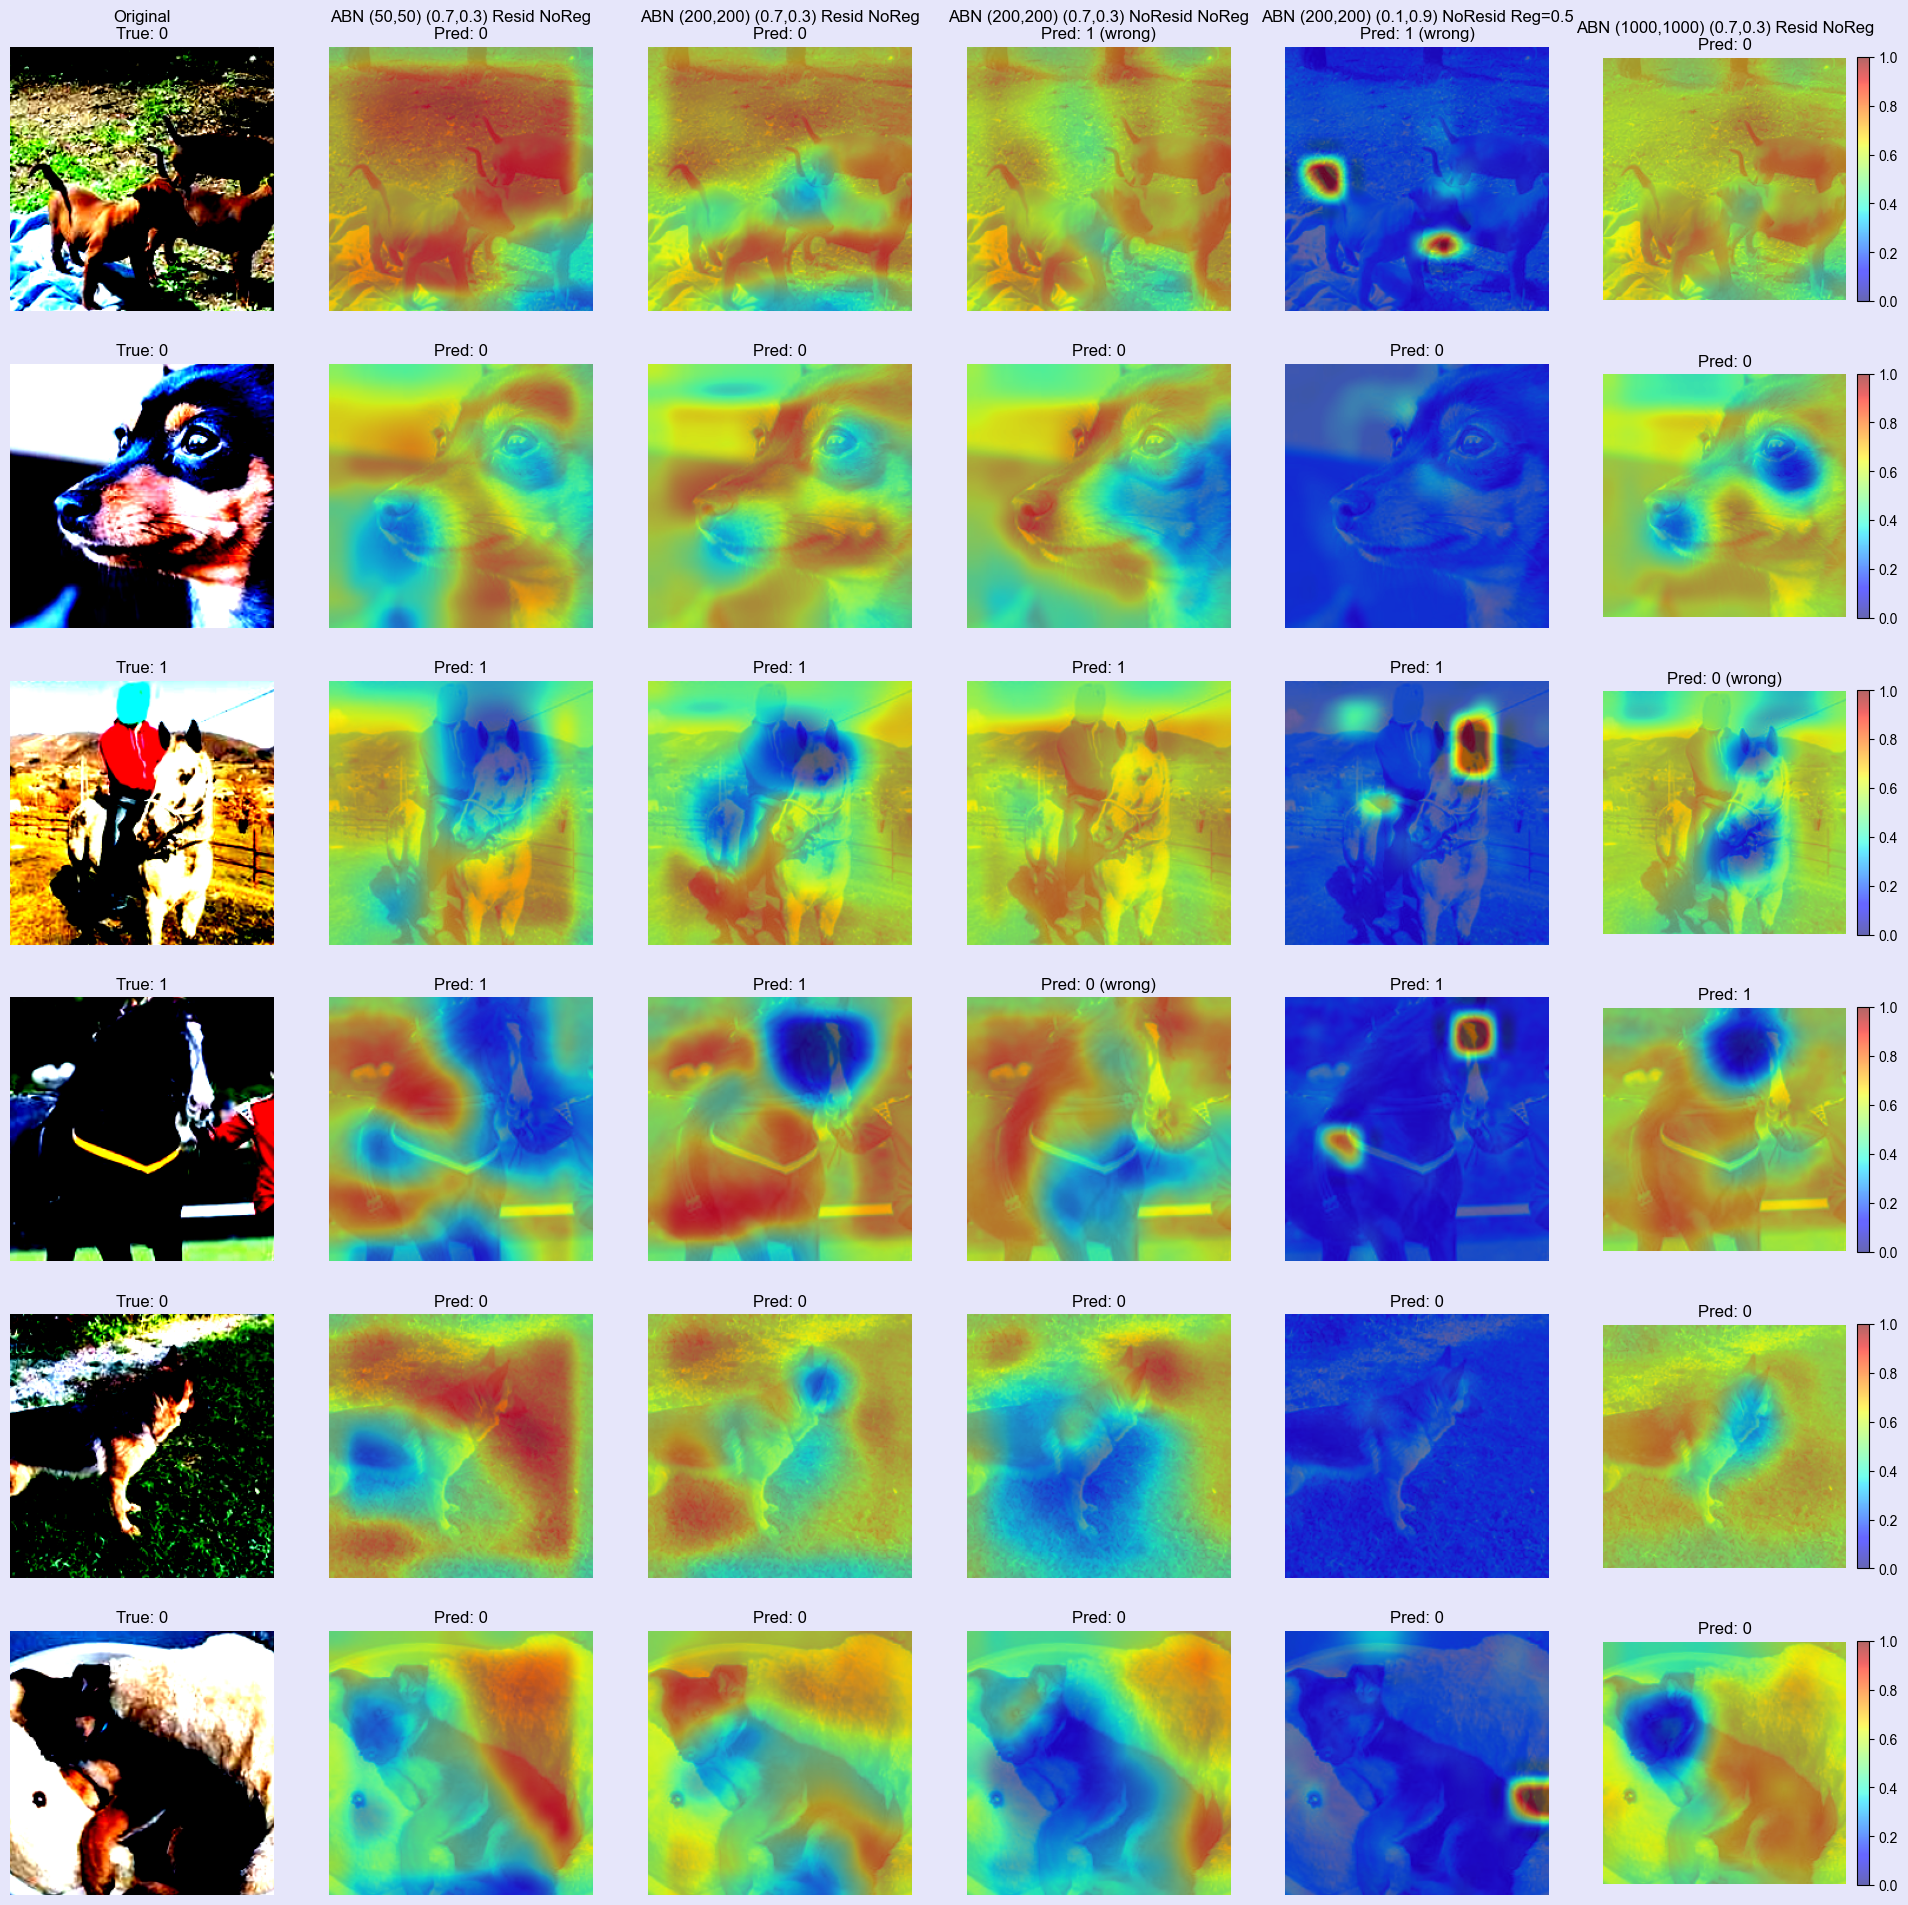

In [ ]:
plt.rcParams.update(
    {
        "font.family": "Arial",
        "font.size": 10,
    }
)


def plot_pred_results(
    pred_results: list[list[PredictResult]],
    result_labels: list[str],
) -> None:
    m, n = len(pred_results[0]), len(pred_results) + 1
    fig, axs = plt.subplots(
        m, n, figsize=(4 * n, 4 * m), squeeze=False, facecolor="lavender"
    )
    for i in range(len(pred_results)):
        for j in range(len(pred_results[0])):
            pred_result = pred_results[i][j]

            if i == 0:
                axs[j, i].imshow(pred_result["image_np"])
                axs[j, i].set_title(f"True: {pred_result['true_label']}")
                axs[j, i].axis("off")

            axs[j, i + 1].imshow(
                np.dot(pred_result["image_np"], [0.2989, 0.5870, 0.1140])
            )
            heatmap = axs[j, i + 1].imshow(
                pred_result["att_np"], alpha=0.6, vmin=0, vmax=1, cmap="jet"
            )
            axs[j, i + 1].axis("off")
            axs[j, i + 1].set_title(
                f"Pred: {pred_result['pred_label']}"
                + (
                    " (wrong)"
                    if pred_result["true_label"] != pred_result["pred_label"]
                    else ""
                )
            )
            if i + 1 == len(pred_results):
                plt.colorbar(heatmap, fraction=0.046, pad=0.04)
            # if pred_result["true_label"] != pred_result["pred_label"]:
            #     axs[j, i + 1].set_facecolor("red")

        axs[0, i + 1].set_title(f"{result_labels[i]}\n{axs[0, i + 1].get_title()}")
        # axs[i, 0].imshow(pred_results[i][idx]["image_np"])
        # axs[i, 0].set_title(f"{setup['name']} - Image")
        # axs[i, 0].axis("off")

        # axs[i, 1].imshow(pred_results[i][idx]["att_np"], cmap="hot")
        # axs[i, 1].set_title(f"{setup['name']} - Attention Map")
        # axs[i, 1].axis("off")
    axs[0, 0].set_title(f"Original\n{axs[0, 0].get_title()}")

    # plt.tight_layout()
    plt.show()


plot_pred_results(
    pred_results,
    [
        "ABN (50,50) (0.7,0.3) Resid NoReg",
        "ABN (200,200) (0.7,0.3) Resid NoReg",
        "ABN (200,200) (0.7,0.3) NoResid NoReg",
        "ABN (200,200) (0.1,0.9) NoResid Reg=0.5",
        "ABN (1000,1000) (0.7,0.3) Resid NoReg",
    ],
)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-2.117904..2.64].


torch.Size([1, 200])
torch.Size([1, 200])


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-2.117904..2.64].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-2.117904..2.5179958].


torch.Size([1, 200])


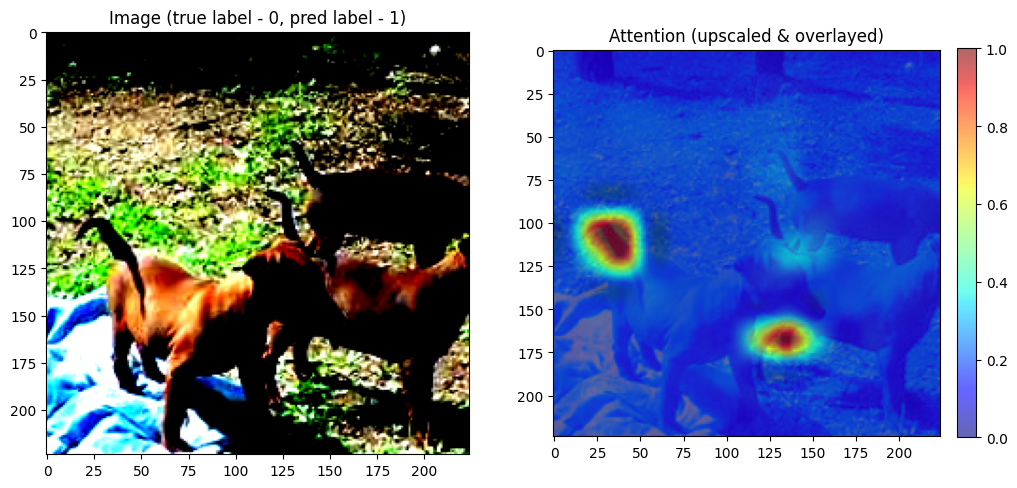

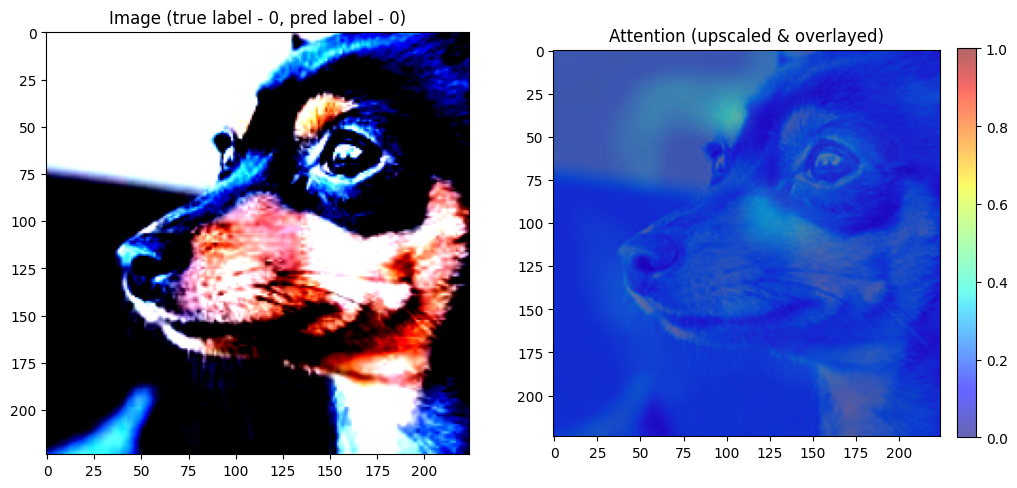

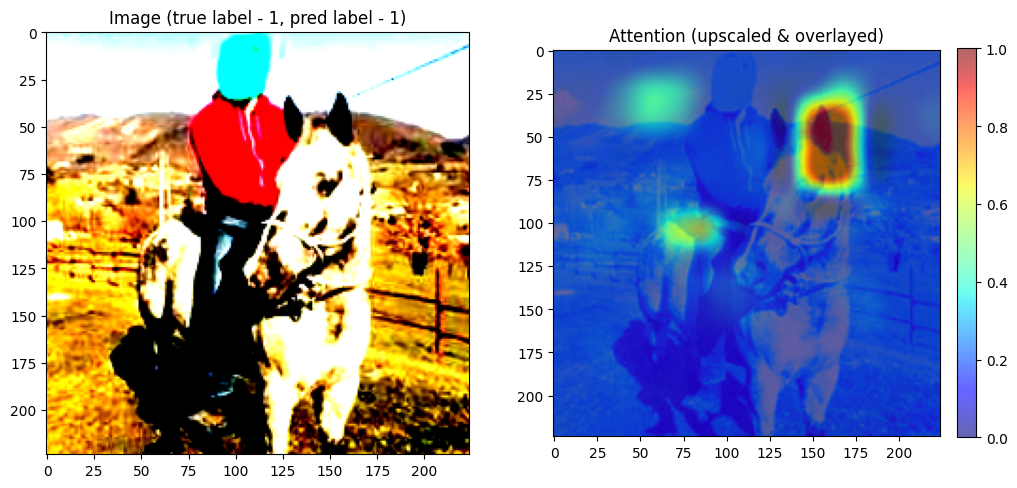

In [ ]:
def visualize_prediction(model: ResNet, image: torch.Tensor, labels: torch.Tensor):
    model.eval()
    with torch.no_grad():
        att_outputs, outputs, [att, feats, per] = model(image[None].to(DEVICE))

    print(att_outputs.shape)

    fig, axs = plt.subplots(1, 2, figsize=(12, 6))
    image_np = image.cpu().numpy().transpose((1, 2, 0))
    att_np = (
        F.resize(att, image_np.shape[:2], interpolation=F.InterpolationMode.BICUBIC)
        .detach()
        .cpu()
        .numpy()[0, 0]
    )

    true_label = labels.argmax().item()
    pred_label = outputs.argmax().item()

    axs[0].imshow(image_np)
    axs[0].set_title(f"Image (true label - {true_label}, pred label - {pred_label})")
    # axs[1].imshow(image_np)
    axs[1].imshow(np.dot(image_np, [0.2989, 0.5870, 0.1140]))
    heatmap = axs[1].imshow(att_np, alpha=0.6, vmin=0, vmax=1, cmap="jet")
    plt.colorbar(heatmap, fraction=0.046, pad=0.04)
    axs[1].set_title("Attention (upscaled & overlayed)")


# for idx in [500, 802, 1001]:
# for idx in [502, 804, 1003]:
for idx in [503, 805, 1004]:
    # for idx in [504, 806, 1005]:
    image, labels = test_dataset[idx]
    visualize_prediction(model, image, labels)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-2.1007793..2.4308496].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-2.117904..2.465708].


torch.Size([1, 1000])
torch.Size([1, 1000])


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-2.117904..2.5877128].


torch.Size([1, 1000])


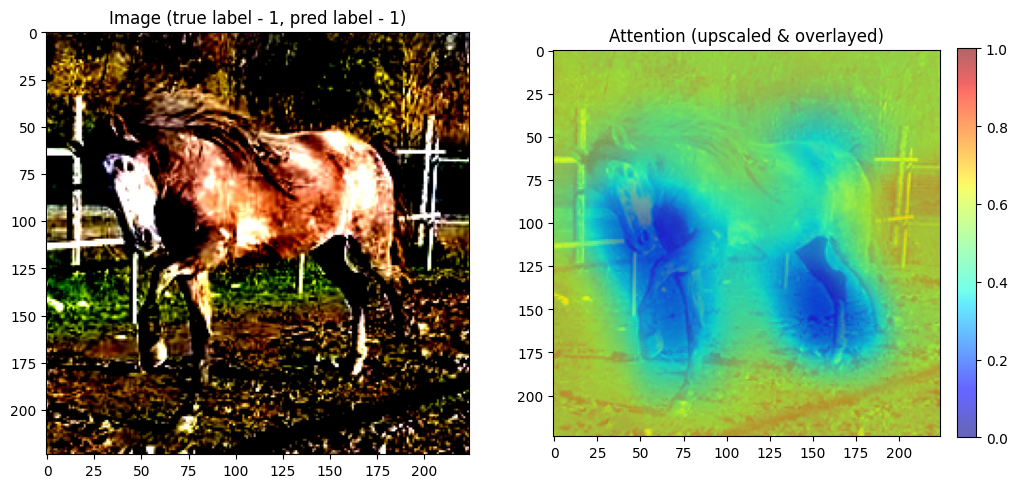

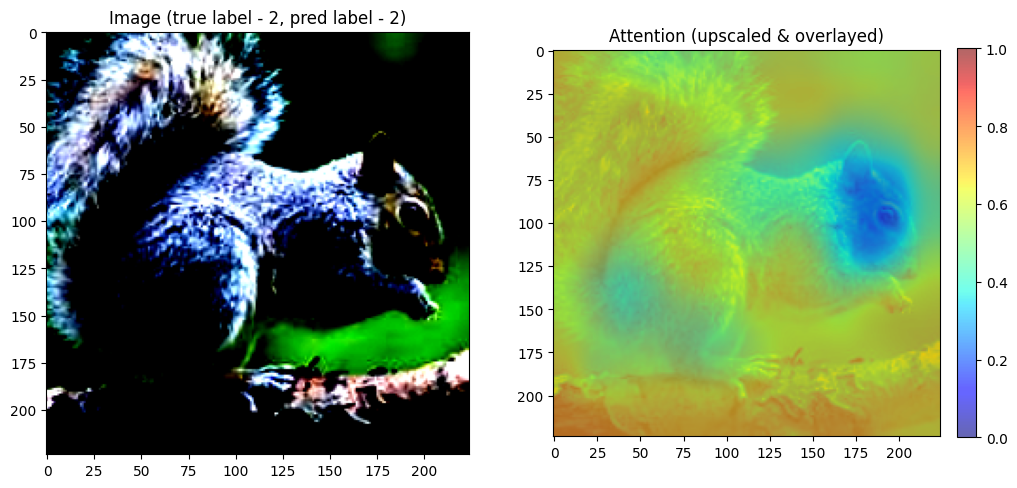

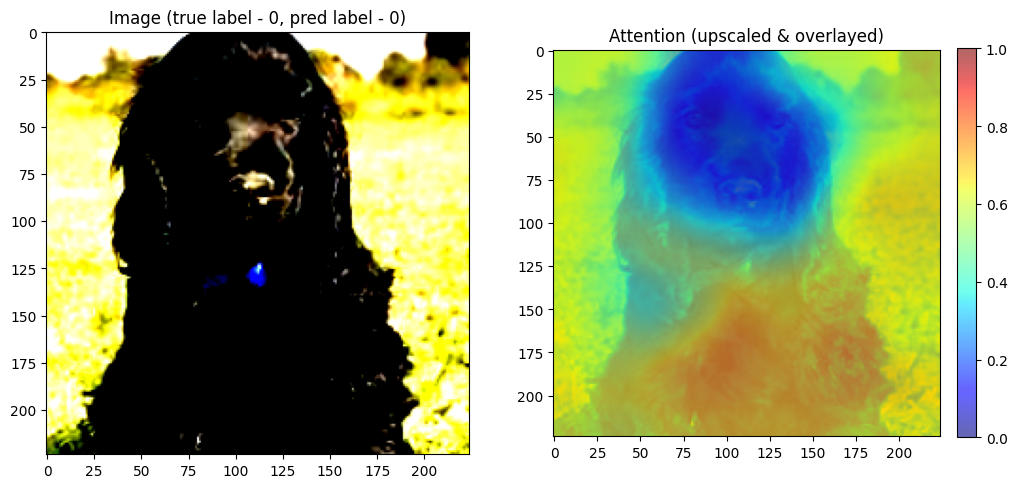

In [14]:
for idx in [300, 702, 1050]:
    image, labels = test_dataset[idx]
    visualize_prediction(model, image, labels)

In [69]:
# @dataclass
# class Metrics:
#     accuracy: float
#     f1_score: float
#     confusion_matrix: np.ndarray


def evaluate_model(
    model: nn.Module, dataloader: DataLoader, device: torch.device
) -> dict[str, Any]:
    model.eval()
    preds_l, labels_l = [], []
    for images, labels in tqdm.tqdm(dataloader, desc="Evaluating"):
        images = images.to(device)
        labels = labels.to(device)

        with torch.no_grad():
            att_outputs, outputs, [att, feats, per] = model(images)
        preds_l.extend(outputs.argmax(-1).cpu().tolist())
        labels_l.extend(labels.argmax(-1).cpu().tolist())

    return classification_report(labels_l, preds_l, output_dict=True)

In [16]:
report_train = evaluate_model(model, train_dataloader, device)
report_train

Evaluating:   5%|▌         | 7/140 [00:22<07:10,  3.24s/it]


KeyboardInterrupt: 

In [70]:
report_test = evaluate_model(model, test_dataloader, DEVICE)
report_test

Evaluating: 100%|██████████| 24/24 [01:12<00:00,  3.03s/it]


{'0': {'precision': 0.9342230695900858,
  'recall': 0.98989898989899,
  'f1-score': 0.9612555174104953,
  'support': 990.0},
 '1': {'precision': 0.977728285077951,
  'recall': 0.8641732283464567,
  'f1-score': 0.9174503657262278,
  'support': 508.0},
 'accuracy': 0.9472630173564753,
 'macro avg': {'precision': 0.9559756773340184,
  'recall': 0.9270361091227233,
  'f1-score': 0.9393529415683616,
  'support': 1498.0},
 'weighted avg': {'precision': 0.9489765071520588,
  'recall': 0.9472630173564753,
  'f1-score': 0.9464003658379934,
  'support': 1498.0}}

In [ ]:
# @dataclass
# class TestConfig:
#     device: torch.device


# @dataclass
# class TestResult:
#     pass


# def test_model(model: nn.Module, config: TestConfig):
#     model.eval()
#     model.to(config.device)
#     with torch.no_grad():
#         for images, labels in tqdm.tqdm(test_dataloader, desc="Testing"):
#             images = images.to(device)
#             labels = labels.to(device)

#             outputs = model(images)
#             loss = loss_fn(outputs, labels.argmax(axis=1))
#             print(f"Test Loss: {loss.item()}")

## Explanations

In [12]:
def read_image_np(path: str | Path) -> np.ndarray:
    path = Path(path)
    image = PIL.Image.open(path)
    return np.asarray(image)


def show_image_np(image: np.ndarray, ax: plt.Axes | None = None) -> plt.Axes:
    if ax is None:
        fig, ax = plt.subplots()
    ax.imshow(image)
    return ax


def show_image(path: str | Path, ax: plt.Axes | None = None) -> plt.Axes:
    path = Path(path)
    if ax is None:
        fig, ax = plt.subplots()
    show_image_np(read_image_np(path))
    return ax

### LIME

In [13]:
from lime import lime_image
from skimage.segmentation import mark_boundaries

In [84]:
class ClassifierWrapper:
    def __init__(self, model: nn.Module, transform: Any, device: torch.device) -> None:
        self.model = model
        self.transform = transform
        self.device = device

    def __call__(self, images: np.ndarray) -> np.ndarray:
        images = torch.tensor(images).permute(0, 3, 1, 2).to(self.device)
        images = torch.stack([self.transform(image) for image in images]).to(
            self.device
        )
        with torch.no_grad():
            logits = self.model(images)
            probs = torch.softmax(logits, dim=-1)
        return probs.cpu().numpy()


def lime_explain(
    model: nn.Module,
    transform: Any,
    image: np.ndarray,
    top_labels: int = 5,
    hide_color: int = 0,
    num_samples: int = 1000,
) -> lime_image.ImageExplanation:
    explainer = lime_image.LimeImageExplainer()
    explanation = explainer.explain_instance(
        image=image,
        classifier_fn=ClassifierWrapper(model, transform, device),
        top_labels=top_labels,
        hide_color=hide_color,
        num_samples=num_samples,
    )
    return explanation

  0%|          | 0/1000 [00:00<?, ?it/s]

Text(0.5, 1.0, 'Pred: 0\nTrue: 0, cane, dog')

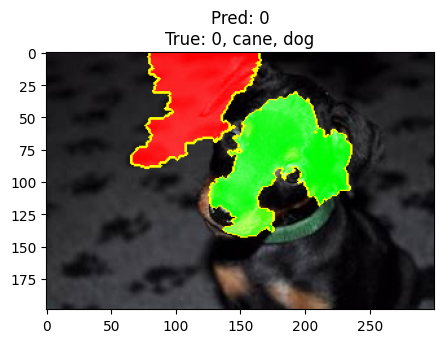

In [85]:
idx = 100

model.eval()

data_entry = train_dataset.data_df.iloc[idx]

lime_explanation = lime_explain(
    model,
    train_dataset.transform,
    read_image_np(train_dataset.data_df.iloc[idx]["path"]),
    num_samples=1000,
)

temp, mask = lime_explanation.get_image_and_mask(
    label=data_entry["label_idx"],
    positive_only=False,
    hide_rest=False,
)
fig, ax = plt.subplots(1, 1, figsize=(5, 5))
show_image_np(mark_boundaries(temp, mask), ax=ax)
ax.set_title(
    f"Pred: {lime_explanation.top_labels[0]}\n"
    + f"True: {data_entry['label_idx']}, {data_entry['italian_label'].value}, {data_entry['english_label'].value}"
)

### SHAP

In [53]:
import shap
import shap.maskers

In [81]:
def shap_explain(
    model: nn.Module, img_path: str | Path, output_names: list[str] | None
) -> shap.Explanation:
    img_np = read_image_np(img_path)
    masker_blur = shap.maskers.Image("blur(5,5)", img_np.shape)
    explainer = shap.Explainer(
        ClassifierWrapper(model, train_dataset.transform, device),
        masker_blur,
        output_names=output_names,
    )

    explanation = explainer(img_np[np.newaxis], max_evals=10000, batch_size=50)

    return explanation


def plot_shap_explanation(explanation: shap.Explanation):
    shap.image_plot(
        shap_values=explanation,
        # shap_values=[vals for vals in np.moveaxis(explanation.values, -1, 0)],
        # pixel_values=explanation.data,
        # labels=explanation.output_names,
    )

  0%|          | 0/9998 [00:00<?, ?it/s]

PartitionExplainer explainer: 2it [00:31, 31.87s/it]               


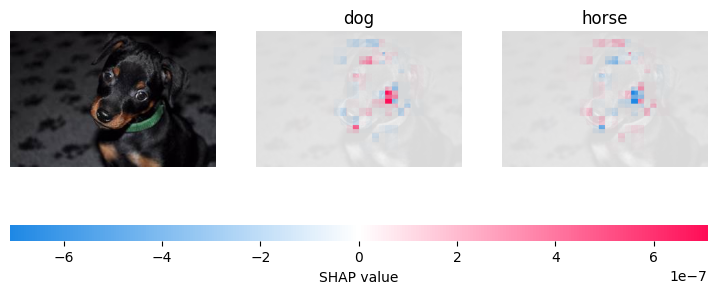

In [ ]:
output_names = (
    train_dataset.data_df.groupby("label_idx")["english_label"]
    .first()
    .sort_values()
    .apply(lambda x: x.value)
    .to_list()
)

idx = 100
shap_explanation = shap_explain(
    model, train_dataset.data_df.iloc[idx]["path"], output_names
)
plot_shap_explanation(shap_explanation)